In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2
os.getcwd()

'D:\\Stat\\Python\\Image_process\\Project-1_Item_recogniser'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
labels_file = open("D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/labels.txt", "r")
labels = [i for i in labels_file.readlines()]
for i in labels:
    if i == labels[-1]:
        a = i[0:-1]
    a = i[0:-2]
    labels[labels.index(i)] = a

In [4]:
indexes = np.unique(np.asanyarray(labels), return_index=True)[1]
labels_cat = [labels[index] for index in sorted(indexes)]
labels_cat.pop()
labels_cat

['chocolate',
 'cookie',
 'drink',
 'bleach',
 'deodorant',
 'tooth paste',
 'olives',
 'meat',
 'milk']

In [5]:
photos_paths = []
counts = []
for i in labels_cat:
    count = len(os.listdir(f"D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/{i}/"))
    counts.append(count)

In [6]:
df_photos = []
n = 0
for i in range(len(labels_cat)):
    for j in range(counts[i]):
        n+=1
        df_photos.append("D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/{}/photo_{}.jpg".format(labels_cat[i],n))

In [7]:
df_labels = pd.Series(labels)
d = {'Image': df_photos, 'Category': df_labels}
df = pd.DataFrame(data = d)

In [8]:
img_height = 100
img_width = 100
batch_size = 15

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/", labels='inferred', label_mode='int', color_mode="rgb", batch_size=20, image_size=(100,
    100), shuffle=True, seed=129, validation_split=0.2, subset="training"
)

Found 100 files belonging to 9 classes.
Using 80 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/", labels='inferred', label_mode='int', color_mode="rgb", batch_size=20, image_size=(100,
    100), shuffle=True, seed=129, validation_split=0.2, subset="validation"
)

Found 100 files belonging to 9 classes.
Using 20 files for validation.


In [11]:
class_names = val_ds.class_names

In [12]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

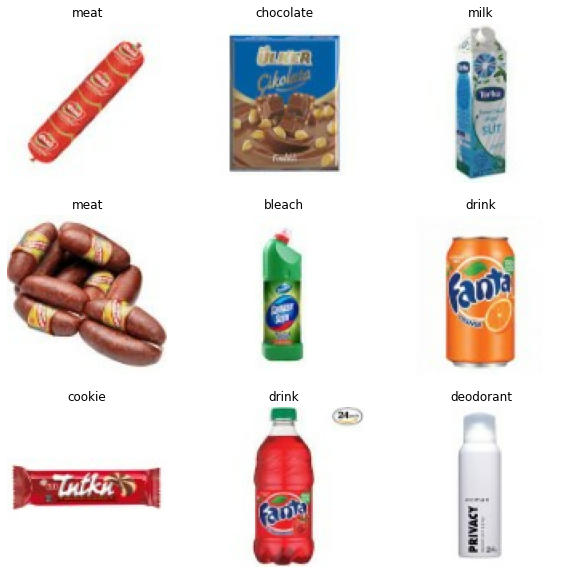

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
model = keras.Sequential([
    keras.layers.Conv2D(64, 4, activation="relu", input_shape=(100,100,3)),
    keras.layers.Conv2D(32, 4, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(9, activation="softmax")
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(train_ds, epochs = 10, batch_size=20, validation_data=val_ds)

Epoch 1/10
4/4 [==============================] - 4s 429ms/step - loss: 883.9262 - accuracy: 0.0833 - val_loss: 86.4938 - val_accuracy: 0.1500
Epoch 2/10
4/4 [==============================] - 0s 39ms/step - loss: 29.6576 - accuracy: 0.2583 - val_loss: 4.7663 - val_accuracy: 0.1500
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 1.0805 - accuracy: 0.7217 - val_loss: 4.8448 - val_accuracy: 0.2500
Epoch 4/10
4/4 [==============================] - 0s 62ms/step - loss: 3.0004 - accuracy: 0.7300 - val_loss: 4.2173 - val_accuracy: 0.1500
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 1.1642 - accuracy: 0.6783 - val_loss: 4.0132 - val_accuracy: 0.2000
Epoch 6/10
4/4 [==============================] - 0s 38ms/step - loss: 1.0459 - accuracy: 0.7817 - val_loss: 6.5701 - val_accuracy: 0.2500
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 0.7183 - accuracy: 0.8117 - val_loss: 6.1196 - val_accuracy: 0.2000
Epoch 8/10
4/4 [======